# 02_Wind_SatDrift_inSBS
---
Feb 06, 2024

Grabbing Polar Pathfinder Sea ice drift (doi: 10.5067/INAWUWO7QH7B) and ERA5 atmospheric reanalysis surface atmospheric conditions (doi: 10.24381/cds.adbb2d47) in SBS region.

Polar Pathfinder Sea ice drift downloaded from https://nsidc.org/data/nsidc-0116/versions/4

ERA5 atmospheric reanalysis downloaded from https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

from common_imports import *

In [ ]:
metpy

### Import polgyon

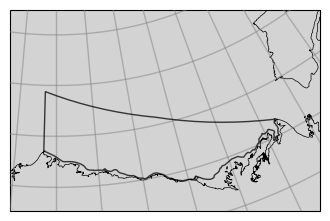

In [2]:
ds_mask = xr.open_dataset('./data/coast_mask_regions.nc')
ds_mask.close()
polyR1 = wkt.loads(str(ds_mask.R1_poly_str.values))
polyR2 = wkt.loads(str(ds_mask.R2_poly_str.values))
coast_poly = wkt.loads(str(ds_mask.coast_poly_masked_str.values))

# create figure
#--------------
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(4,3), subplot_kw=dict(projection=map_projection))
ax.patch.set_facecolor('lightgray')
ax.set_extent([200, 235, 69, 75], crs=ccrs.PlateCarree())  
add_coast(ax, scale='10m', color='k', linewidth=0.5, alpha=1, zorder=3)
add_grid(ax, lats=np.arange(68,80,2), lons=np.arange(180,260,5), linewidth=1, color='gray', alpha=0.5, zorder=4)

ax.add_geometries([coast_poly], edgecolor='k', linestyle='solid', facecolor='None',alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)


## Find indices of Polar Pathfinder EASE grid coordinates within SBS

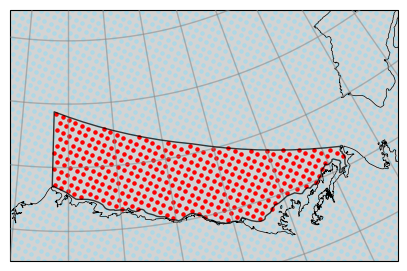

In [3]:
# create figure
#--------------
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(5,4), subplot_kw=dict(projection=map_projection))
ax.patch.set_facecolor('lightgray')
ax.set_extent([200, 235, 69, 75], crs=ccrs.PlateCarree())  
add_coast(ax, scale='10m', color='k', linewidth=0.5, alpha=1, zorder=3)
add_grid(ax, lats=np.arange(68,80,2), lons=np.arange(180,260,5), linewidth=1, color='gray', alpha=0.5, zorder=4)

# create polygon from specified polygon corners
#----------------------------------------------
ax.add_geometries([coast_poly], edgecolor='k', linestyle='solid', facecolor='None',alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)

# grab ice drift
#---------------
date = datetime(year = 2020, month = 11, day = 1, hour = 12, minute = 0)
lons, lats, u, v = grab_ice_Drift(date = date, lat_range=[67, 78], lon_range=[195, 240],
                                  return_vars = ['lon', 'lat', 'u', 'v'])
    
# below is the time-intensive portion!
#-------------------------------------
# add within-polygon indicies of lat/lon coords to dict
poly_indices = within_polygon_indices(coast_poly, lats, lons, quiet=True)

lats_d = np.array([])
lons_d = np.array([])
# grab drift grid coordinates for each pair
for pair in poly_indices:
    lats_d = np.append(lats_d, lats[pair[0], pair[1]])
    lons_d = np.append(lons_d, lons[pair[0], pair[1]])
    
plt.scatter(lons, lats, s=5, color='lightblue' ,transform=ccrs.PlateCarree())
plt.scatter(lons_d, lats_d, s=5, color='red', transform=ccrs.PlateCarree())

## Grab average ice drift vector in SBS region over time

In [4]:
#===========================================================
start_date = datetime(year = 2020, month = 11, day = 1, hour = 12, minute = 0)
end_date = datetime(year = 2021, month = 6, day = 1, hour = 1, minute = 0)
#===========================================================
ice_dates = [start_date + timedelta(days=nd) for nd in range((end_date-start_date).days + 1)]

u_ice = np.array([])
v_ice = np.array([])

for date in ice_dates:
    
    # grab ice drift
    #---------------
    returned = grab_ice_Drift(date = date, lat_range=[67, 78], lon_range=[195, 240],
                              return_vars = ['u', 'v'])
    u, v = returned

    u_date = np.array([])
    v_date = np.array([])
    
    for pair in poly_indices:
        u_date = np.append(u_date, u[pair[0], pair[1]])
        v_date = np.append(v_date, v[pair[0], pair[1]])
        
    u_ice = np.append(u_ice, np.nanmean(u_date))
    v_ice = np.append(v_ice, np.nanmean(v_date))

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_90580/939122555.py:25: RuntimeWarning: Mean of empty slice
  u_ice = np.append(u_ice, np.nanmean(u_date))
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_90580/939122555.py:26: RuntimeWarning: Mean of empty slice
  v_ice = np.append(v_ice, np.nanmean(v_date))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


xlims: 2020-11-01 00:00:00 ---- 2021-06-01 00:00:00


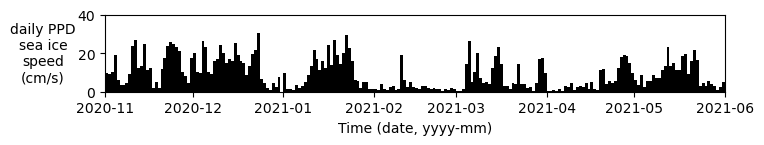

In [5]:
# make plot
#----------
fig, ax = plt.subplots(figsize=(8,1))
ax.bar(ice_dates, np.sqrt(u_ice**2+v_ice**2), facecolor='k', width=1)
ax.set_ylabel('daily PPD\nsea ice\nspeed\n(cm/s)', c='k', rotation=0, labelpad=25, verticalalignment='center')
ax.set_ylim(0,40)

ax.legend(bbox_to_anchor=(0.2,1.1), edgecolor='none', facecolor='none')

# x ticks
#--------
XMIN = ice_dates[0]-timedelta(hours=12)
XMAX = ice_dates[-1]+timedelta(hours=12)
print(f'xlims: {XMIN} ---- {XMAX}')
ax.set_xlim(XMIN, XMAX)
ax.set_xlabel('Time (date, yyyy-mm)');

# save_name = f"./figures/KeyFigs/CoastRegion_PPD_{start_date.strftime('%m.%d')}_{end_date.strftime('%m.%d')}_v7.png"
# print(f'>>> save as: {save_name}')
# fig.savefig(f"{save_name}",  transparent=True, 
#             bbox_inches="tight", pad_inches = 0.05, dpi=200)

## Save to file

In [6]:
# OUTPUT_FILE = './data/SBS_PPD_icedrift.nc'

# ds = xr.Dataset(
#         data_vars=dict(u=(["time"], u_ice, {"units": "cm/s"}),
#                        v=(["time"], v_ice, {"units": "cm/s"})),
#         coords=dict(time = (["time"], ice_dates)),
#         attrs=dict(description="PPD sea ice drift in coast region"))

# ds.u.plot()
# ds.to_netcdf(path=OUTPUT_FILE, mode='w', format="NETCDF4")   

## Find indices of ERA5 grid coordinates within SBS

In [7]:
def calc_weightmean_ERA_inpoly(poly_indices_ERA, lat_ERA_pol, dsERA):

    u10_pol = np.array([])
    v10_pol = np.array([])
    msl_pol = np.array([])

    for pair in poly_indices_ERA:
        u10_pol = np.append(u10_pol, dsERA.u10[:, pair[0], pair[1]])
        v10_pol = np.append(v10_pol, dsERA.v10[:, pair[0], pair[1]])
        msl_pol = np.append(msl_pol, dsERA.msl[:, pair[0], pair[1]])

    u10_pol_reshape = np.reshape(u10_pol, (int(len(u10_pol)/len(dsERA.time)), len(dsERA.time)))
    v10_pol_reshape = np.reshape(v10_pol, (int(len(v10_pol)/len(dsERA.time)), len(dsERA.time)))
    msl_pol_reshape = np.reshape(msl_pol, (int(len(msl_pol)/len(dsERA.time)), len(dsERA.time)))

    weights = np.cos(np.deg2rad(lat_ERA_pol))

    u10_weighted = np.meshgrid(u10_pol_reshape[0,:], weights)[1] * u10_pol_reshape
    v10_weighted = np.meshgrid(v10_pol_reshape[0,:], weights)[1] * v10_pol_reshape
    msl_weighted = np.meshgrid(msl_pol_reshape[0,:], weights)[1] * msl_pol_reshape


    u10_mean = np.sum(u10_weighted, axis=0)/np.sum(weights)
    v10_mean = np.sum(v10_weighted, axis=0)/np.sum(weights)
    msl_mean = np.sum(msl_weighted, axis=0)/np.sum(weights)
    
    return u10_mean, v10_mean, msl_mean
    

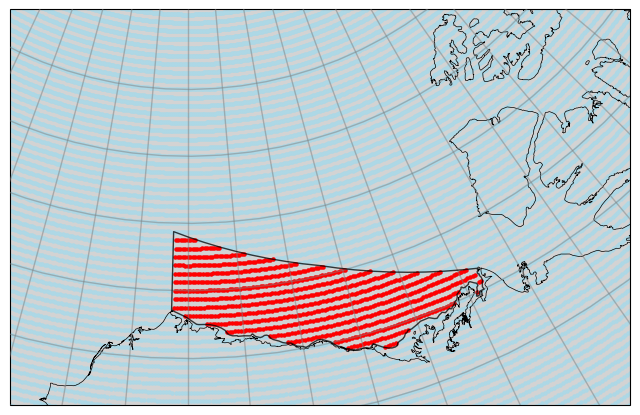

In [8]:

dsERA = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2021.nc')
dsERA.close()
dsERA = shift_bylons(dsERA)

# grab time range
#======================================================================
# dsERA = dsERA.sel(time=slice('2021-03-01T00:00:00.000000000','2021-04-30T23:00:00.000000000'))
dsERA = dsERA.sel(time=slice('2021-01-01T00:00:00.000000000','2021-05-31T23:00:00.000000000'))
#======================================================================
lon_ERA, lat_ERA = np.meshgrid(dsERA.longitude.values, dsERA.latitude.values)

# below is the time-intensive portion!
#-------------------------------------
# add within-polygon indicies of lat/lon coords to dict
poly_indices_ERA = within_polygon_indices(coast_poly, lat_ERA, lon_ERA, quiet=True)


# create figure
#--------------
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=map_projection))
ax.patch.set_facecolor('lightgray')
ax.set_extent([191,242, 68,78], crs=ccrs.PlateCarree())  
add_coast(ax, scale='10m', color='k', linewidth=0.5, alpha=1, zorder=3)
add_grid(ax, lats=np.arange(68,80,2), lons=np.arange(180,260,5), linewidth=1, color='gray', alpha=0.5, zorder=4)

ax.add_geometries([coast_poly], edgecolor='k', linestyle='solid', facecolor='None',alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)

lat_ERA_pol = np.array([])
lon_ERA_pol = np.array([])
# grab drift grid coordinates for each pair
for pair in poly_indices_ERA:
    lat_ERA_pol = np.append(lat_ERA_pol, lat_ERA[pair[0], pair[1]])
    lon_ERA_pol = np.append(lon_ERA_pol, lon_ERA[pair[0], pair[1]])
    
plt.scatter(lon_ERA, lat_ERA, s=5, color='lightblue' ,transform=ccrs.PlateCarree())
plt.scatter(lon_ERA_pol, lat_ERA_pol, s=5, color='red', transform=ccrs.PlateCarree())


### ERA5: 2020

In [9]:
# open ERA5 data
dsERA20 = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2020.nc')
dsERA20.close()
dsERA20 = shift_bylons(dsERA20)

# grab time range
#======================================================================
dsERA20 = dsERA20.sel(time=slice('2020-11-01T00:00:00.000000000','2020-12-31T23:00:00.000000000'))
#======================================================================

wind_time_20 = dsERA20.time.values

u10_mean_20, v10_mean_20, msl_mean_20 = calc_weightmean_ERA_inpoly(poly_indices_ERA, lat_ERA_pol, dsERA20)

# wind_time_20, u10_mean_20, v10_mean_20, msl_mean_20 = np.array([]),np.array([]),np.array([])

### ERA5: 2021

In [10]:
# open ERA5 data
dsERA21 = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2021.nc')
dsERA21.close()
dsERA21 = shift_bylons(dsERA21)

# grab time range
#======================================================================
dsERA21 = dsERA21.sel(time=slice('2021-01-01T00:00:00.000000000','2021-06-01T00:00:00.000000000'))
#======================================================================
wind_time_21 = dsERA21.time.values

u10_mean_21, v10_mean_21, msl_mean_21 = calc_weightmean_ERA_inpoly(poly_indices_ERA, lat_ERA_pol, dsERA21)

### Combine ERA5 for continuous winter time series

In [11]:
# wind_time = wind_time_21
# wind_u = u10_mean_21* units('meter/second')
# wind_v = v10_mean_21* units('meter/second')
# msl = msl_mean_21

# wind_dir = metpy.calc.wind_direction(wind_u, wind_v, convention='from')
# wind_speed = np.sqrt(wind_u**2 + wind_v**2).magnitude

In [13]:
wind_time = np.append(wind_time_20, wind_time_21)

msl = (np.append(msl_mean_20, msl_mean_21) * units('Pa') ).to('hPa')
wind_u = np.append(u10_mean_20, u10_mean_21) * units('meter/second')
wind_v = np.append(v10_mean_20, v10_mean_21) * units('meter/second')

wind_dir = metpy.calc.wind_direction(wind_u, wind_v, convention='from')
wind_speed = np.sqrt(wind_u**2 + wind_v**2).magnitude

NameError: name 'metpy' is not defined

In [ ]:
wind_speed

### save to file

In [ ]:
OUTPUT_FILE = './data/SBS_ERA5_hourly.nc'


ds = xr.Dataset(
        data_vars=dict(
            u=(["time"], wind_u.magnitude, {"units": "meter/second"}),
            v=(["time"], wind_v.magnitude, {"units": "meter/second"}),
            msl=(["time"], msl.magnitude, {"units": "hPa"}),
            wind_dir=(["time"], wind_dir.magnitude, {"units": "degree"}),
            wind_speed=(["time"], wind_speed, {"units": "meter/second"})
        ),
    
        coords=dict(time = (["time"], wind_time)),
        attrs=dict(description="Hourly ERA5 in coast region"),
    )

ds.u.plot()


ds.to_netcdf(path=OUTPUT_FILE, 
             mode='w', format="NETCDF4") 

### Plot msl

In [ ]:

fig, ax = plt.subplots(figsize=(8,1))

ax.plot(wind_time, msl, c='k')

# y axis
ax.set_ylabel('msl\n(hPa)', rotation='horizontal', labelpad=20, va='center')
ax.set_yticks([1000,1030,1060])

# x axis
ti = pd.to_datetime(wind_time[0])
tf = pd.to_datetime(wind_time[-1])
ax.set_xlim(ti, tf)
ax.set_xlabel('Time (date, yyyy-mm)')


# # save figure
# #------------
# savename = f"./figures/CoastRegion_msl_{ti.strftime('%m.%d')}_{tf.strftime('%m.%d')}.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, transparent=True, bbox_inches="tight", pad_inches = 0, dpi=200)


### Plot wind vectors

In [ ]:

fig, ax = plt.subplots(figsize=(8,1))

sp=3
winds = ax.quiver(wind_time[::sp], np.zeros_like(wind_u[::sp]), wind_u[::sp], wind_v[::sp], 
                  width=0.0015, headwidth=0, scale=250)
ax.quiverkey(winds, X=.9, Y=0.8, U=10, label = '', labelpos='E')
ax.text(0.845, 0.9, '        10 m/s', transform=ax.transAxes,
    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=1), zorder = 0)


# y axis
ax.set_ylabel('10m\nwind', rotation='horizontal', labelpad=20, va='center')
ax.set_yticks([])
ax.set_ylim(-0.9,1.1)

# x axis
ti = pd.to_datetime(wind_time[0])
tf = pd.to_datetime(wind_time[-1])
ax.set_xlim(ti-timedelta(days=2), tf+timedelta(days=2))

    
# # save figure
# #------------
# savename = f"./figures/CoastRegion_windvec_{ti.strftime('%m.%d')}_{tf.strftime('%m.%d')}.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, transparent=True, bbox_inches="tight", pad_inches = 0, dpi=200)


### Plot wind speed

In [ ]:

fig, ax = plt.subplots(figsize=(8,1))

ax.plot(wind_time, wind_speed, c='k', lw=1)

# y axis
ax.set_ylabel('wind\nspeed\n(m/s)', rotation='horizontal', labelpad=20, va='center')
ax.set_yticks([0,5,10,15])
ax.set_ylim(0,16)
# x axis
ti = pd.to_datetime(wind_time[0])
tf = pd.to_datetime(wind_time[-1])
ax.set_xlim(ti, tf)
ax.set_xlabel('Time (date, yyyy-mm)')

# ax.set_yticks([])
# ax2 = ax.twinx()
# ax2.set_ylabel('wind\nspeed\n(m/s)', rotation='horizontal', labelpad=20, va='center')
# ax2.set_yticks([0,5,10,15])
# ax2.set_ylim(0,15)

    
# ax2.plot(wind_time, wind_speed, c='k', lw=1)

# x axis
# ti = pd.to_datetime(wind_time[0])
# tf = pd.to_datetime(wind_time[-1])
# ax2.set_xlim(ti, tf)


# save figure
#------------
savename = f"./figures/KeyFigs/CoastRegion_windsp_{ti.strftime('%m.%d')}_{tf.strftime('%m.%d')}_v4.png"
print(f'>>> save as: {savename}')
fig.savefig(savename, transparent=True, bbox_inches="tight", pad_inches = 0, dpi=200)
